In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import regex
import re
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import classification_report
plt.style.use('ggplot')
%matplotlib notebook

## Fonction qui a pour objectif de néttoyer le corpus de text que l'on souhaite étudier:

In [2]:
def fonction_nettoyage_text(df):
    # supprission des ponctuations
    rm_ponct = str.maketrans('','',string.punctuation)
    df = df.apply(lambda x:x.translate(rm_ponct))
    # suppression les unicodes
    df = df.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
                                                
    # suppression des URLs
    df = df.apply(lambda x:re.sub(r'http\S+',"",x))
    
    # suppression des stopwords
    stop_en = stopwords.words("english")
    df = df.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
                                                  # Lemmatisation
    df = df.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
                  
    return(df)

Dans cette notebook, on va plutôt nous intéresser au résumés des annonces d'offre d'emploi plutôt qu'à l'ensemble du descriptif de l'offre pour réduire la dimension au niveau du nombre de mots que l'on va disposer, donc alléger notre corpus.On veut aussi savoir si les résumés représentent bien les offres.

In [3]:
# import des données
dataset = pd.read_csv("data_set_version_final.csv")
dataset.resume=fonction_nettoyage_text(dataset.resume)

On se basera pour commencer avec la méthode TF-IDF pour représenter chaque document dans notre corpus. Mais tout d'abord revérifiant les caractérisqtiques de nos lables.

In [4]:
classes, nbpoint = np.unique(dataset["Labels"], return_counts=True)
print("On a {} classes :\n{}\n\n".format(len(classes),classes))
for ind, cl in enumerate(classes):
    print("Pour la classe {}, on a {} nombres de lignes".format(cl, nbpoint[ind] ))
print("Nombre de points total:",len(dataset["Labels"]))

On a 11 classes :
['Finance_actuariat' 'chirurgien' 'cryptography' 'data scientist'
 'dentist' 'developer' 'ditital_marketing' 'network_engineer' 'nurse'
 'pharmacist' 'robotic']


Pour la classe Finance_actuariat, on a 5087 nombres de lignes
Pour la classe chirurgien, on a 26462 nombres de lignes
Pour la classe cryptography, on a 10560 nombres de lignes
Pour la classe data scientist, on a 11374 nombres de lignes
Pour la classe dentist, on a 27495 nombres de lignes
Pour la classe developer, on a 7380 nombres de lignes
Pour la classe ditital_marketing, on a 12088 nombres de lignes
Pour la classe network_engineer, on a 12336 nombres de lignes
Pour la classe nurse, on a 36287 nombres de lignes
Pour la classe pharmacist, on a 21094 nombres de lignes
Pour la classe robotic, on a 19058 nombres de lignes
Nombre de points total: 189221


## Split train-test validation:

In [5]:
X_train,X_test,Y_train,y_test = train_test_split(dataset.resume,dataset.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

### Prédiction des types d'emplois à partir de l'algorithme KNN:

In [6]:
def ConfusionMatrix(Y_predict, Y_true):
    confusion_matrix(Y_true, Y_predict,labels=np.unique(Y_true))
    confu = pd.DataFrame(confusion_matrix(Y_true, Y_predict,labels=np.unique(Y_true)),columns=np.unique(Y_true),index=np.unique(Y_true))
    confu["marge_true"]=confu.sum(axis=1)
    confu.loc["marge_pred"]=confu.sum(axis=0)
    
    return confu

In [7]:
pipline=Pipeline([('tfidf',TfidfVectorizer()),('knn',KNeighborsClassifier())])

In [8]:
pipline.set_params(knn__n_neighbors=5)
pipline.fit(x_train,y_train)
pipline.score(x_val,y_val)

0.9538213755442031

Calcul de la valeur du meilleur paramètre n_neighbors:

100%|██████████| 8/8 [43:45<00:00, 345.46s/it]


With all being CV, best k is 2 and best perf is 0.9665550997810605


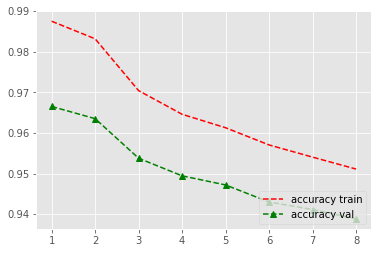

In [9]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    pipline.set_params(knn__n_neighbors=k)
    y_pred_train = pipline.predict(x_train)
    y_pred_val=pipline.predict(x_val)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

In [10]:
k_opt=k_values[perf_val.index(max(perf_val))]
pipline.set_params(knn__n_neighbors=k_opt)
pipline.fit(X_train,Y_train)
pipline.score(X_test,y_test)
pred_test=pipline.predict(X_test)
d=ConfusionMatrix(Y_predict=pred_test,Y_true=y_test)
print("Le score de notre modèle sur les données test={}".format(np.mean(pred_test==y_test)))
d

Le score de notre modèle sur les données test=0.9756196381700636


,Finance_actuariat,chirurgien,cryptography,data scientist,dentist,developer,ditital_marketing,network_engineer,nurse,pharmacist,robotic,marge_true
Finance_actuariat,1586,0,0,0,0,0,0,0,0,0,0,1586
chirurgien,1,7749,0,0,55,6,1,0,79,6,3,7900
cryptography,0,3,3147,4,0,1,0,2,1,1,2,3161
data scientist,5,9,1,3342,7,6,5,1,4,2,4,3386
dentist,1,88,4,8,7979,1,2,3,48,5,1,8140
developer,2,7,2,25,3,2168,1,4,7,4,4,2227
ditital_marketing,0,2,1,5,6,4,3539,1,2,0,2,3562
network_engineer,0,3,10,6,1,2,3,3678,3,1,9,3716
nurse,4,303,6,27,173,8,22,15,10417,43,11,11029
pharmacist,0,32,1,7,19,5,6,4,105,6091,4,6274


In [11]:
print(classification_report(y_test, pred_test))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      1.00      1.00      1586
       chirurgien       0.94      0.98      0.96      7900
     cryptography       0.99      1.00      0.99      3161
   data scientist       0.97      0.99      0.98      3386
          dentist       0.97      0.98      0.97      8140
        developer       0.98      0.97      0.98      2227
ditital_marketing       0.99      0.99      0.99      3562
 network_engineer       0.99      0.99      0.99      3716
            nurse       0.98      0.94      0.96     11029
       pharmacist       0.99      0.97      0.98      6274
          robotic       0.99      0.98      0.99      5786

        micro avg       0.98      0.98      0.98     56767
        macro avg       0.98      0.98      0.98     56767
     weighted avg       0.98      0.98      0.98     56767



 ### Prédiction des types d'emplois à partir de l'algorithme SVM:

In [12]:
pipline_svm=Pipeline([('tfidf',TfidfVectorizer()),('LSVM',LinearSVC())])

In [43]:
pipline_svm.set_params(LSVM__C=2)
pipline_svm.fit(x_train,y_train)
pipline_svm.score(x_val,y_val)

0.9900093112212799

## Parametre C optimal de l'algorithme SVM:

12it [01:17,  7.89s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
13it [01:50, 15.25s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
14it [02:26, 21.56s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
15it [02:50, 22.30s/it]



 C optimal = 1.6378937069540647


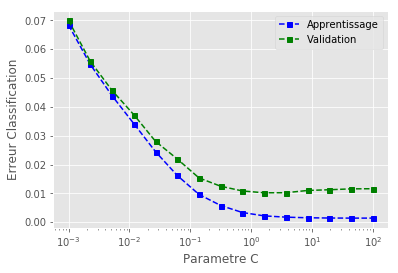

In [13]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_svm.set_params(LSVM__C=C)
    pipline_svm.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

## Score obtenu avec la meilleure valeur de C sur les données test:

In [14]:
pipline_svm.set_params(LSVM__C=Copt)
pipline_svm.fit(X_train, Y_train)
pred=pipline_svm.predict(X_test)
score_svm=accuracy_score(y_test, pipline_svm.predict(X_test))
print("Le score optimal pour svm={}".format(score_svm))
ConfusionMatrix(pred,y_test)

Le score optimal pour svm=0.9922314020469639


,Finance_actuariat,chirurgien,cryptography,data scientist,dentist,developer,ditital_marketing,network_engineer,nurse,pharmacist,robotic,marge_true
Finance_actuariat,1586,0,0,0,0,0,0,0,0,0,0,1586
chirurgien,0,7805,0,1,30,0,0,0,55,8,1,7900
cryptography,0,0,3155,0,0,0,0,2,0,0,4,3161
data scientist,3,3,0,3363,4,6,2,0,2,1,2,3386
dentist,0,28,0,0,8064,1,1,0,44,1,1,8140
developer,0,0,0,6,0,2210,2,0,2,3,4,2227
ditital_marketing,0,0,0,3,1,1,3552,3,1,1,0,3562
network_engineer,0,1,0,0,0,0,0,3711,0,1,3,3716
nurse,0,62,4,7,36,5,0,2,10872,41,0,11029
pharmacist,0,2,0,2,9,1,0,1,24,6235,0,6274


In [ ]:
print(classification_report(y_test, pred))

 ### Prédiction des types d'emplois à partir de la regression logistique:

In [15]:
pipline_RL=Pipeline([('tfidf',TfidfVectorizer()),('RL',LogisticRegression())])

In [16]:
pipline_RL.set_params(RL__C=2)
pipline_RL.fit(x_train,y_train)
pipline_RL.score(x_val,y_val)

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9844225784533307

15it [04:10, 26.18s/it]



 C optimal = 43.93970560760795


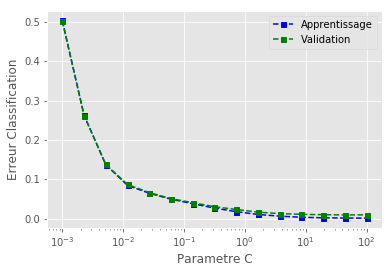

In [17]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_RL.set_params(RL__C=C)
    pipline_RL.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_RL.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_RL.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [18]:
pipline_RL.set_params(RL__C=Copt)
pipline_RL.fit(X_train, Y_train)
pred=pipline_RL.predict(X_test)
score_RL=accuracy_score(y_test, pipline_RL.predict(X_test))
print("Le score optimal pour RL={}".format(score_RL))
ConfusionMatrix(pred,y_test)

Le score optimal pour RL=0.9930417319921786


,Finance_actuariat,chirurgien,cryptography,data scientist,dentist,developer,ditital_marketing,network_engineer,nurse,pharmacist,robotic,marge_true
Finance_actuariat,1586,0,0,0,0,0,0,0,0,0,0,1586
chirurgien,0,7815,0,1,28,0,0,0,47,8,1,7900
cryptography,0,0,3155,0,0,0,0,2,0,0,4,3161
data scientist,2,3,0,3365,1,4,0,0,6,1,4,3386
dentist,0,27,0,0,8070,1,0,0,41,0,1,8140
developer,0,0,0,6,0,2211,2,0,2,2,4,2227
ditital_marketing,0,0,0,3,1,0,3554,0,4,0,0,3562
network_engineer,0,1,0,0,0,0,0,3711,0,1,3,3716
nurse,0,65,3,6,26,4,0,2,10892,31,0,11029
pharmacist,0,2,0,2,7,1,0,1,22,6239,0,6274


In [ ]:
print(classification_report(y_test, pred))

## Naive Baysian:

In [19]:
pipline_NB=Pipeline([('tfidf',TfidfVectorizer()),('NB',MultinomialNB())])

In [20]:
pipline_NB.set_params(NB__alpha=1e-3)
pipline_NB.fit(x_train,y_train)
pipline_NB.score(x_val,y_val)

0.958627978961673

### Optimisation du paramètre $\alpha$ :

24it [02:05,  6.37s/it]



 C optimal = 0.01


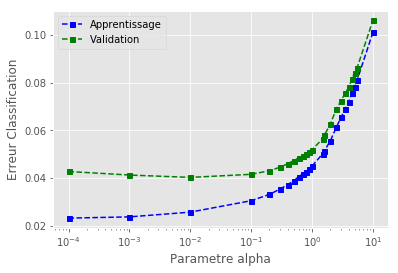

In [21]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_NB.set_params(NB__alpha=C)
    pipline_NB.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_NB.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_NB.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

On constate que plus $\alpha$ est grand plus on évite un l'overfiting. 

In [22]:
pipline_NB.set_params(NB__alpha=Copt)
pipline_NB.fit(X_train, Y_train)
pred=pipline_NB.predict(X_test)
score_NB=accuracy_score(y_test, pipline_NB.predict(X_test))
print("Le score optimal pour NB={}".format(score_NB))
ConfusionMatrix(pred,y_test)

Le score optimal pour NB=0.9640988602533161


,Finance_actuariat,chirurgien,cryptography,data scientist,dentist,developer,ditital_marketing,network_engineer,nurse,pharmacist,robotic,marge_true
Finance_actuariat,1575,0,0,9,1,0,0,0,1,0,0,1586
chirurgien,0,7414,0,10,181,0,8,0,249,20,18,7900
cryptography,0,0,3137,3,1,4,0,4,4,0,8,3161
data scientist,12,6,3,3280,4,15,3,5,31,3,24,3386
dentist,1,103,0,10,7752,0,27,3,221,17,6,8140
developer,6,5,0,24,1,2137,8,5,12,6,23,2227
ditital_marketing,1,6,1,11,9,3,3510,0,6,1,14,3562
network_engineer,0,6,18,7,9,1,0,3637,2,4,32,3716
nurse,3,222,6,12,73,3,3,1,10610,85,11,11029
pharmacist,0,26,1,9,21,0,7,1,215,5993,1,6274


In [23]:
print(classification_report(y_test, pred))

                   precision    recall  f1-score   support

Finance_actuariat       0.98      0.99      0.99      1586
       chirurgien       0.95      0.94      0.94      7900
     cryptography       0.99      0.99      0.99      3161
   data scientist       0.96      0.97      0.97      3386
          dentist       0.96      0.95      0.96      8140
        developer       0.99      0.96      0.97      2227
ditital_marketing       0.98      0.99      0.98      3562
 network_engineer       0.99      0.98      0.98      3716
            nurse       0.93      0.96      0.95     11029
       pharmacist       0.98      0.96      0.97      6274
          robotic       0.98      0.98      0.98      5786

        micro avg       0.96      0.96      0.96     56767
        macro avg       0.97      0.97      0.97     56767
     weighted avg       0.96      0.96      0.96     56767



## Remarque:
sur chaque algorithme que l'on a testé, on remarque que entre le métier de chirurgien et infirmier,les algorithmes font plus d'erreur. Réalisons alors sur ces deux types de métiers une prédiction binaire pour savoir à quel point on peut se tromper en se focalisans que sur ces deux metiers.

In [24]:
bol=[True if k=="nurse" or k=="chirurgien" else False for k in dataset.Labels]
dataset1=dataset[bol]
X_train,X_test,Y_train,y_test = train_test_split(dataset1.resume,dataset1.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

In [25]:
classes, nbpoint = np.unique(dataset1["Labels"], return_counts=True)
print("On a {} classes :\n{}\n\n".format(len(classes),classes))
for ind, cl in enumerate(classes):
    print("Pour la classe {}, on a {} nombres de lignes".format(cl, nbpoint[ind] ))
print("Nombre de points total:",len(dataset1["Labels"]))

On a 2 classes :
['chirurgien' 'nurse']


Pour la classe chirurgien, on a 26462 nombres de lignes
Pour la classe nurse, on a 36287 nombres de lignes
Nombre de points total: 62749


In [26]:
classes, nbpoint = np.unique(y_test, return_counts=True)
print("On a {} classes :\n{}\n\n".format(len(classes),classes))
for ind, cl in enumerate(classes):
    print("Pour la classe {}, on a {} nombres de lignes".format(cl, nbpoint[ind] ))
print("Nombre de points total:",len(y_test))

On a 2 classes :
['chirurgien' 'nurse']


Pour la classe chirurgien, on a 7778 nombres de lignes
Pour la classe nurse, on a 11047 nombres de lignes
Nombre de points total: 18825


On a bien 2 classes maintenant avec 62749 points.

## Modèle avec le KNN:

100%|██████████| 8/8 [21:07<00:00, 149.44s/it]

With all being CV, best k is 2 and best perf is 0.9757929883138564


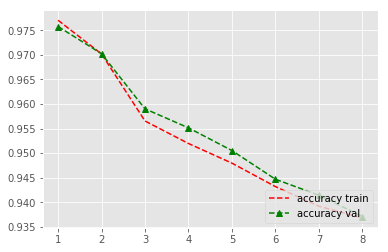

In [27]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    pipline.set_params(knn__n_neighbors=k)
    y_pred_train = pipline.predict(x_train)
    y_pred_val=pipline.predict(x_val)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

In [28]:
k_opt=k_values[perf_val.index(max(perf_val))]
pipline.set_params(knn__n_neighbors=k_opt)
pipline.fit(X_train,Y_train)
pipline.score(X_test,y_test)
pred_test=pipline.predict(X_test)
pred_prob_knn=pipline.predict_proba(X_test)
d=ConfusionMatrix(Y_predict=pred_test,Y_true=y_test)
print("Le score de notre modèle sur les données test={}".format(np.mean(pred_test==y_test)))
d

Le score de notre modèle sur les données test=0.9716865869853918


,chirurgien,nurse,marge_true
chirurgien,7661,117,7778
nurse,416,10631,11047
marge_pred,8077,10748,18825


In [29]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

  chirurgien       0.95      0.98      0.97      7778
       nurse       0.99      0.96      0.98     11047

   micro avg       0.97      0.97      0.97     18825
   macro avg       0.97      0.97      0.97     18825
weighted avg       0.97      0.97      0.97     18825



On constate que l'algorithme se trompe souvent losqu'on prédit un chirugien au lieu de prédire un infirmier

## Modèle avec SVM:

12it [00:14,  1.28s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
13it [00:15,  1.43s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
14it [00:17,  1.56s/it]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
15it [00:19,  1.66s/it]



 C optimal = 1.6378937069540647


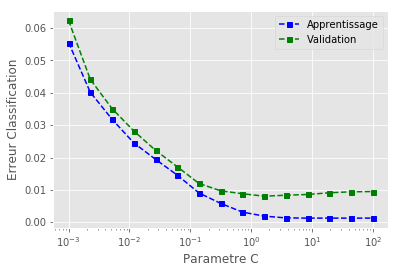

In [30]:
pipline_svm=Pipeline([('tfidf',TfidfVectorizer()),('LSVM',LinearSVC())])
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_svm.set_params(LSVM__C=C)
    pipline_svm.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [31]:
pipline_svm=Pipeline([('tfidf',TfidfVectorizer()),('LSVM',LinearSVC())])
pipline_svm.set_params(LSVM__C=Copt)

lsvc=LinearSVC(C=Copt)
clf = CalibratedClassifierCV(lsvc) 
pipline_svm.fit(X_train, Y_train)

clf.fit(TfidfVectorizer().fit(X_train).transform(X_train), Y_train)
pred_svm=pipline_svm.predict(X_test)
pred_prob_svm=clf.predict_proba(TfidfVectorizer().fit(X_train).transform(X_test))
score_svm=accuracy_score(y_test, pipline_svm.predict(X_test))
print("Le score optimal pour svm={}".format(score_svm))
ConfusionMatrix(pred_svm,y_test)

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Le score optimal pour svm=0.9935192563081009


,chirurgien,nurse,marge_true
chirurgien,7711,67,7778
nurse,55,10992,11047
marge_pred,7766,11059,18825


In [32]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

  chirurgien       0.99      0.99      0.99      7778
       nurse       0.99      1.00      0.99     11047

   micro avg       0.99      0.99      0.99     18825
   macro avg       0.99      0.99      0.99     18825
weighted avg       0.99      0.99      0.99     18825



Pour svm, on a l'erreur du premier espèce qui est plus important que l'erreur du second espèce

## Modèle avec la regression logistique:

0it [00:00, ?it/s]/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
15it [00:17,  1.25s/it]



 C optimal = 43.93970560760795


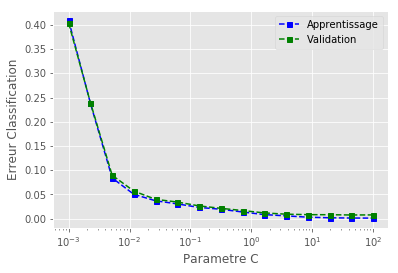

In [33]:
pipline_RL=Pipeline([('tfidf',TfidfVectorizer()),('RL',LogisticRegression())])
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_RL.set_params(RL__C=C)
    pipline_RL.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_RL.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_RL.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [34]:
pipline_RL.set_params(RL__C=Copt)
pipline_RL.fit(X_train, Y_train)
pred_RL=pipline_RL.predict(X_test)
pred_prob_RL=pipline_RL.predict_proba(X_test)
score_RL=accuracy_score(y_test, pipline_RL.predict(X_test))
print("Le score optimal pour RL={}".format(score_RL))
ConfusionMatrix(pred_RL,y_test)

Le score optimal pour RL=0.9936254980079682


,chirurgien,nurse,marge_true
chirurgien,7713,65,7778
nurse,55,10992,11047
marge_pred,7768,11057,18825


In [39]:
print(classification_report(y_test, pred_RL))

              precision    recall  f1-score   support

  chirurgien       0.99      0.99      0.99      7778
       nurse       0.99      1.00      0.99     11047

   micro avg       0.99      0.99      0.99     18825
   macro avg       0.99      0.99      0.99     18825
weighted avg       0.99      0.99      0.99     18825



On a un erreur du première espèce qui est plus important

## Modèle de prédiction avec Naive Bayse:

In [35]:
pipline_NB=Pipeline([('tfidf',TfidfVectorizer()),('NB',MultinomialNB())])

24it [00:25,  1.06s/it]



 C optimal = 0.01


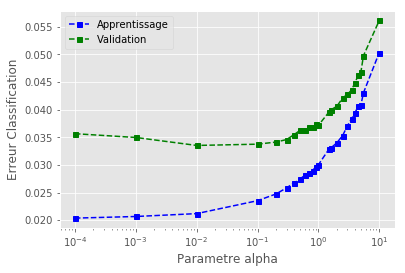

In [36]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    pipline_NB.set_params(NB__alpha=C)
    pipline_NB.fit(x_train, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, pipline_NB.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(y_train, pipline_NB.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [37]:
pipline_NB.set_params(NB__alpha=Copt)
pipline_NB.fit(X_train, Y_train)
pred_NB=pipline_NB.predict(X_test)
pred_prob_NB=pipline_NB.predict_proba(X_test)
score_NB=accuracy_score(y_test, pipline_NB.predict(X_test))
print("Le score optimal pour NB={}".format(score_NB))
ConfusionMatrix(pred_NB,y_test)

Le score optimal pour NB=0.9680743691899071


,chirurgien,nurse,marge_true
chirurgien,7461,317,7778
nurse,284,10763,11047
marge_pred,7745,11080,18825


In [48]:
print(classification_report(y_test, pred_NB))

              precision    recall  f1-score   support

  chirurgien       0.96      0.96      0.96      7778
       nurse       0.97      0.97      0.97     11047

   micro avg       0.97      0.97      0.97     18825
   macro avg       0.97      0.97      0.97     18825
weighted avg       0.97      0.97      0.97     18825



### Courbe ROC:

In [40]:
def ROC_param(y_test,y_pred,y_proba):   
    fpr_cl = dict()
    tpr_cl = dict()
    roc_auc=dict()

    fpr_cl["classe 0"], tpr_cl["classe 0"], _ = roc_curve(y_test == 0, y_proba[:, 0].ravel())
    roc_auc["classe 0"] = auc(fpr_cl["classe 0"], tpr_cl["classe 0"])
    fpr_cl["classe 1"], tpr_cl["classe 1"], _ = roc_curve(y_test, y_proba[:, 1].ravel())  
    roc_auc["classe 1"] = auc(fpr_cl["classe 1"], tpr_cl["classe 1"])
    
    prob_pred = np.array([y_proba[i, 1 if c else 0] for i, c in enumerate(y_pred)])
    fpr_cl["tout"], tpr_cl["tout"], _ = roc_curve((y_pred == y_test).ravel(), prob_pred)
    roc_auc["tout"] = auc(fpr_cl["tout"], tpr_cl["tout"])
    
    return fpr_cl,tpr_cl,roc_auc


In [41]:
le = LabelBinarizer()
le.fit(y_test)
y_test1=le.transform(y_test)
pred1=le.transform(pred_test)
pred_svm1=le.transform(pred_svm)
pred_RL1=le.transform(pred_RL)
pred_NB1=le.transform(pred_NB)
fpr_knn,tpr_knn,auc_knn=ROC_param(y_test1,pred1,pred_knn)
fpr_svm,tpr_svm,auc_svm=ROC_param(y_test1,pred_svm1,pred_prob_svm)
fpr_RL,tpr_RL,auc_RL=ROC_param(y_test1,pred_RL1,pred_prob_RL)
fpr_NB,tpr_NB,auc_NB=ROC_param(y_test1,pred_NB1,pred_prob_NB)

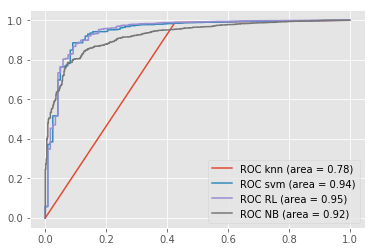

In [42]:
for cl in ("tout",):
    plt.plot(fpr_knn[cl], tpr_knn[cl], label='ROC knn (area = %0.2f)'% (auc_knn[cl]) )
    plt.plot(fpr_svm[cl], tpr_svm[cl], label='ROC svm (area = %0.2f)' % (auc_svm[cl]))
    plt.plot(fpr_RL[cl], tpr_RL[cl], label='ROC RL (area = %0.2f)'% (auc_RL[cl]))
    plt.plot(fpr_NB[cl], tpr_NB[cl], label='ROC NB (area = %0.2f)'% (auc_NB[cl]))
plt.legend()
plt.show()

On constate sur ce courbe que le modèle SMV et regression logistique maximise plus l'air sous la courbe ROC. Donc ces deux modèles donne des résultats plus pretinant sur l'ensemble des classes que l'on dispose. 

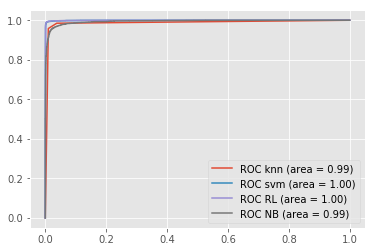

In [43]:

for cl in ("classe 0",):
    plt.plot(fpr_knn[cl], tpr_knn[cl], label='ROC knn (area = %0.2f)'% (auc_knn[cl]) )
    plt.plot(fpr_svm[cl], tpr_svm[cl], label='ROC svm (area = %0.2f)' % (auc_svm[cl]))
    plt.plot(fpr_RL[cl], tpr_RL[cl], label='ROC RL (area = %0.2f)'% (auc_RL[cl]))
    plt.plot(fpr_NB[cl], tpr_NB[cl], label='ROC NB (area = %0.2f)'% (auc_NB[cl]))
plt.legend()
plt.show()


Sur la classe 0 qui correspond au chirurgien, on peut dire la même chose qu'avant.

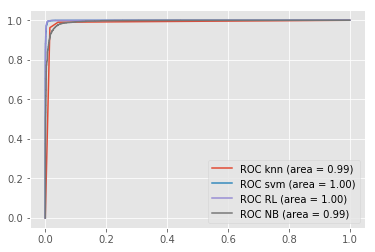

In [44]:
for cl in ("classe 1",):
    plt.plot(fpr_knn[cl], tpr_knn[cl], label='ROC knn (area = %0.2f)'% (auc_knn[cl]) )
    plt.plot(fpr_svm[cl], tpr_svm[cl], label='ROC svm (area = %0.2f)' % (auc_svm[cl]))
    plt.plot(fpr_RL[cl], tpr_RL[cl], label='ROC RL (area = %0.2f)'% (auc_RL[cl]))
    plt.plot(fpr_NB[cl], tpr_NB[cl], label='ROC NB (area = %0.2f)'% (auc_NB[cl]))
plt.legend()
plt.show()

Il en est de même pour la classe nurse